In [1]:
# Import useful packages

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pandas as pd
from matplotlib import rcParams
import sys
from netCDF4 import Dataset, MFDataset,num2date,date2num
import netCDF4
import os
import glob

In [38]:
# Pick a date range to access some test data and make some plots:

start_date = dt.datetime(2019,8,9)
stop_date = dt.datetime(2019,8,13)
years = ['2019']
months = ['08']

# Function to making appending data files easier:
flatten = lambda l: [item for sublist in l for item in sublist]


### 1) Gridded air temperature

In [39]:
# To plot INP ambient, we need to know air temperature at cloud height. 

# The gridded temperature product 'mergesonde', is an interpolation of 
# twice daily radiosonde profiles, merged with temperature retrievals from 
# the HATPro microwave radiometer. Upper level temperatures (above burst height)
# are filled with near-real time forecast data from ecmwf. 

# Load some mergesonde data: 
temp=[]
pres=[]
mixr=[]
times=[]
mergesonde_path = '/gws/nopw/j04/ncas_radar_vol1/heather/mergesonde/merged-mwroe/'
fnames1 = [glob.glob(mergesonde_path + 'smtmergesondeX1.a1.' + dt.datetime.strftime(dat,'%Y%m%d') +'*.cdf')[0] for dat in pd.date_range(start_date,stop_date,freq='1D')]
for fil in fnames1:
    nc = Dataset(fil,'r')
    heights = nc['height'][:] # km asl
    times.append(pd.to_datetime(nc['base_time'][:] + nc['time_offset'][:],origin='unix',unit='s')) # minutely
    pres.append(np.transpose(nc['pres_merge'][:,:])) # Pressure in mb
    temp.append(np.transpose(nc['temp_merge'][:,:])) # Temperature in celcius
    mixr.append(np.transpose(nc['mixr_merge'][:,:])) # Mixing ratio in g/kg

mergesonde_t = pd.DataFrame(index = flatten(times),columns=heights,data=flatten(temp))

/tmp/ipykernel_16052/4229470101.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rf = ax1.pcolormesh(mergesonde_t.index,heights,np.transpose(mergesonde_t.to_numpy(dtype=np.float)))


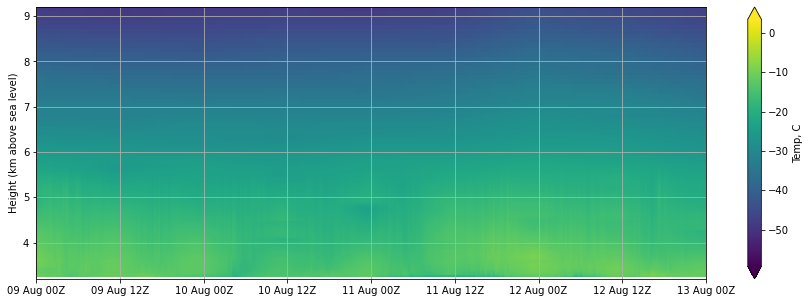

In [40]:
# Plot gridded temperature as a fuction of height and time

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
rf = ax1.pcolormesh(mergesonde_t.index,heights,np.transpose(mergesonde_t.to_numpy(dtype=np.float))) 
cb = fig.colorbar(rf,label='Temp, C',extend='both')
ax1.set_ylabel('Height (km above sea level)')
ax1.xaxis.set_major_formatter(md.DateFormatter('%d %b %HZ'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=12))

ax1.set_ylim(3,13)
ax1.set_xlim(start_date,stop_date)
ax1.set_ylim(3.2, 3.2+6)
ax1.grid('on')

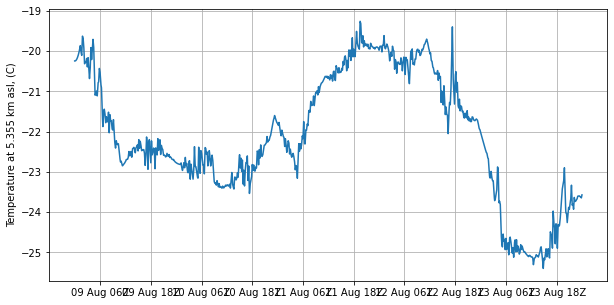

In [41]:
# But where is cloud height? Could use statistical properites to pick a 'typical' summer cloud 
# height value. I.e. in Shupe et al, 2011 (High and Dry), it looks like a typical height is ~ 3km asl

# To make a time series of the temperature at a certain height:

# This function finds the closest point in a gridded array to a specified value: 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Choose a height to plot
plot_height_agl = 2.1 # km
plot_height = plot_height_agl + 3.25 # km above sea level

# Extract data from array
height_ind = find_nearest(heights,plot_height)
t_time_series = mergesonde_t[heights[height_ind]]

# Make figure
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(t_time_series.index,t_time_series)
ax1.grid(True)
ax1.set_ylabel('Temperature at %s km asl, (C)'%heights[height_ind])
ax1.xaxis.set_major_formatter(md.DateFormatter('%d %b %HZ'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=12))


### 2) Radar reflectivity for cloud prescence / height

In [42]:
# Or, we could get cloud height / location from the radar (MMCR)
# Download some radar data: 

# Get data 
mmcr_path = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mmcr/processed/'
all_files = []
f_date_list = pd.date_range(start_date.date(),stop_date.date(),freq='1D')
for date in f_date_list:
    day_of_year = (date.date()).timetuple().tm_yday
    all_files.append(glob.glob(mmcr_path+ 'smtmmcrmomX1.b1.%s*.cdf'%dt.datetime.strftime(date,format='%Y%m%d')))

all_files = flatten(all_files)
all_files.sort()

# Extract data
mmcr_nc = netCDF4.MFDataset(all_files,'r')

# Select radar mode (0,1,2,3) (time)
# For operating mode details see Moran et al., 1998; 
mode = 3

# Get heights for particular mode
# Range Heights (center of radar sample volume), magl.
# (mode, heights)
Heights = mmcr_nc.variables['heights'][mode,:]
Heights = Heights[Heights.mask == False]

# Get mode/ time
ModeNum = mmcr_nc.variables['ModeNum'][:]    

# Get data quality status and subset for modes
DataQualityStatus = mmcr_nc.variables['DataQualityStatus'][:]
DataQualityStatus = DataQualityStatus[np.where(ModeNum==mode)]

# Get Signal to Noise ratio
# dB, (time, heights)
# Remove signal to noise ratio < -14
SignalToNoiseRatio = mmcr_nc.variables['SignalToNoiseRatio'][:,0:len(Heights)]
SignalToNoiseRatio = SignalToNoiseRatio[np.where(ModeNum==mode)]

# Get reflectivity and subset for mode and heights. Remove bad s2n. 
# Reflectiity, dBZ (time, heights)
Reflectivity = mmcr_nc.variables['Reflectivity'][:,0:len(Heights)]
Reflectivity = Reflectivity[np.where(ModeNum==mode)]
Reflectivity = np.ma.masked_where(SignalToNoiseRatio<-14,Reflectivity)  

# Get times: 
for i in range(0, len(all_files)):
    mmcr_temp = netCDF4.Dataset(all_files[i],'r')
    # Get mode/ time
    ModeNum = mmcr_temp.variables['ModeNum'][:]    
    base_time = pd.to_datetime(mmcr_temp.variables['base_time'][:],origin='unix',unit='s')
    temp_times = pd.to_datetime(mmcr_temp.variables['time_offset'][:],origin=base_time,unit='s')
    # Subset times for mode
    temp_times = temp_times[np.where(ModeNum==mode)]        
    if i==0:
        all_times = temp_times
    else:
        all_times = np.append(all_times,temp_times)

/tmp/ipykernel_16052/57131059.py:25: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  Heights = mmcr_nc.variables['heights'][mode,:]
/tmp/ipykernel_16052/57131059.py:29: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  ModeNum = mmcr_nc.variables['ModeNum'][:]
/tmp/ipykernel_16052/57131059.py:32: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  DataQualityStatus = mmcr_nc.variables['DataQualityStatus'][:]
/tmp/ipykernel_16052/57131059.py:38: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  SignalToNoiseRatio = mmcr_nc.variables['SignalToNoiseRatio'][:,0:len(Heights)]
/tmp/ipykernel_16052/57131059.py:43: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  Reflectivity = mmcr_nc.variables['Reflectivity'][:,0:len(Heights)]
/tmp/ipykernel_160

/tmp/ipykernel_16052/162737918.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


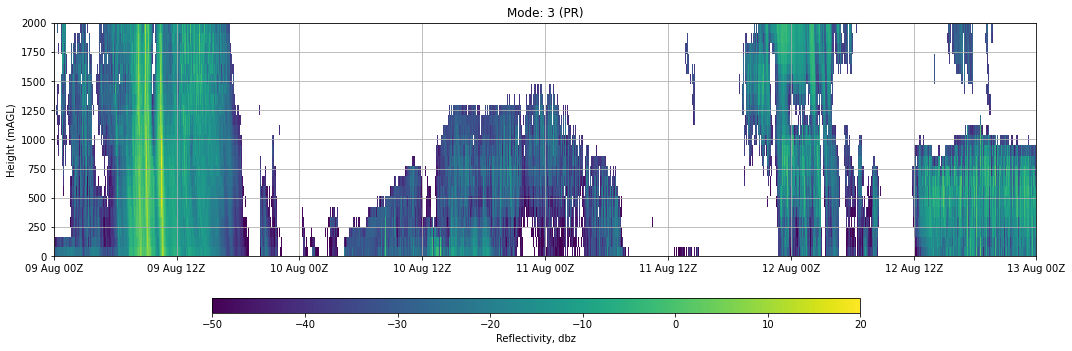

In [43]:
# Plot radar reflectivity

fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(111)
rf = ax1.pcolormesh(all_times,Heights,np.transpose(Reflectivity),vmin=-50, vmax=20) 
ax1.set_ylabel('Height (mAGL)')
ax1.xaxis.set_major_formatter(md.DateFormatter('%d %b %HZ'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=12))
ax1.set_ylim(0,2000)
ax1.set_xlim(start_date,stop_date)
ax1.grid('on')
ax1.set_title('Mode: 3 (PR)')
cbar_ax1 = fig.add_axes([0.2, -0.1, 0.6, 0.05])
fig.colorbar(rf,cax=cbar_ax1,label='Reflectivity, dbz',orientation='horizontal')
fig.tight_layout()

In [44]:
# An example of getting cloud height from the radar might be as follows:
# For each time step, find the heighest pixel where reflectivity > -30 dbz (I just picked this out of the air)

cloud_top_height = np.ones(np.shape(Reflectivity)[0]) * -9999
threshold = -30 # Check what's best to use for this. 

for i in range(0,np.shape(Reflectivity)[0]):
    try:
        max_height_ind = np.max(np.where(Reflectivity[i,:].filled(-9999) > threshold)[0])
        cloud_top_height[i] = Heights[max_height_ind]
    except:
        continue

# Get 'cloud top temperature' from mergesonde: 
cloud_top_temp = np.ones(np.shape(Reflectivity)[0]) * -9999

for i in range(0,np.shape(Reflectivity)[0]):
    cloud_height = (cloud_top_height[i]/1000) + 3.25 # km above sea level
    merge_height_ind = find_nearest(heights,cloud_height)
    try:
        cloud_top_temp[i] = mergesonde_t.loc[pd.to_datetime(all_times[i]).round('min')][heights[merge_height_ind]]
    except:
        continue

# Mask times when there is no cloud    
cloud_top_height = np.ma.masked_values(cloud_top_height, -9999)
cloud_top_temp = np.ma.masked_where(cloud_top_temp<-90,cloud_top_temp)

(-10.0, -30.0)

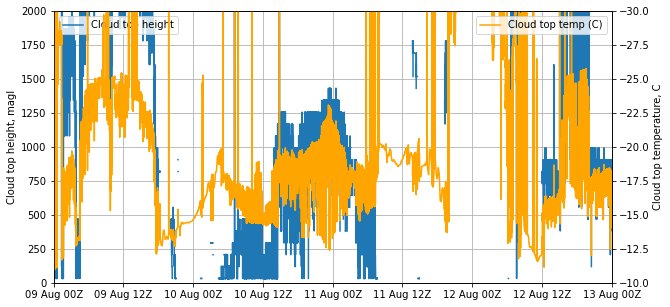

In [45]:
# Plot derived 'cloud top height' alongside 'cloud top temperature' from mergesonde
# Ultimately might want to filter out some of the spikes. 

# Make figure
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(all_times,cloud_top_height,label='Cloud top height')
ax1.grid(True)
ax1.set_ylabel('Cloud top height, magl')
ax1.xaxis.set_major_formatter(md.DateFormatter('%d %b %HZ'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=12))
ax1.set_xlim(start_date,stop_date)
ax1.set_ylim(0,2000)
ax1.legend(loc = 'upper left')

ax2 = ax1.twinx()
ax2.plot(all_times,cloud_top_temp,label='Cloud top temp (C)',c='orange')
ax2.set_ylabel('Cloud top temperature, C')
ax2.legend(loc='upper right')
ax2.set_ylim(-10,-30)



### 3) Liquid water path

/tmp/ipykernel_16052/1316082071.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mwrret['lwp'][mwrret['lwp']==-999]=np.nan
/tmp/ipykernel_16052/1316082071.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mwrret['pwv'][mwrret['pwv']==-999]=np.nan


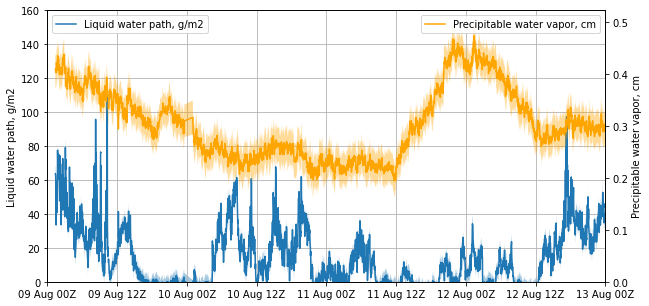

In [46]:
# To compare observered liquid water path to UM liquid water path
# Access observed LWP from retrieved from the HATPro microwave radiometer
# The retrieval is call MWRRET

mwrret_path = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mwr/mwrret3/'
dayrange = pd.date_range(start_date,stop_date,freq='1D')
lwp=[]
lwp_uncertainty=[]
lwp_qc=[]
pwv=[]
pwv_uncertainty=[]
all_mwr_times=[]

for day in dayrange:
    fpath = glob.glob(mwrret_path + 'smtmwrret3turnX1.c1.%s*'%day.strftime(format='%Y%m%d'))[0]
    mwrret = netCDF4.Dataset(fpath)
    base_time = pd.to_datetime(mwrret.variables['base_time'][:],origin='unix',unit='s')
    times = pd.to_datetime(mwrret.variables['time_offset'][:],origin=base_time,unit='s')
    all_mwr_times.append(times)
    lwp.append(mwrret.variables['phys_lwp'][:])
    lwp_uncertainty.append(mwrret.variables['phys_lwp_uncertainty'][:])
    pwv.append(mwrret.variables['phys_pwv'][:])
    pwv_uncertainty.append(mwrret.variables['phys_pwv_uncertainty'][:])
    lwp_qc.append(mwrret.variables['phys_qc_flag'][:])
    
# Put into dataframe and clean
mwrret = pd.DataFrame({'lwp': flatten(lwp),'lwp_uncertainty': flatten(lwp_uncertainty),'pwv': flatten(pwv),'pwv_uncertainty': flatten(pwv_uncertainty),'lwp_qc':flatten(lwp_qc)},index=flatten(all_mwr_times))

# qc --> remove all values during times when qc!=0
mwrret[mwrret['lwp_qc']!=0]=np.nan
mwrret['lwp'][mwrret['lwp']==-999]=np.nan
mwrret['pwv'][mwrret['pwv']==-999]=np.nan



# Plot liquid water path and precipitable water vapor

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.fill_between(mwrret.index,mwrret['lwp']+mwrret['lwp_uncertainty'],mwrret['lwp']-mwrret['lwp_uncertainty'],alpha =0.4 )
ax1.plot(mwrret['lwp'],label='Liquid water path, g/m2')
ax1.grid(True)
ax1.set_ylabel('Liquid water path, g/m2')
ax1.xaxis.set_major_formatter(md.DateFormatter('%d %b %HZ'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=12))
ax1.set_xlim(start_date,stop_date)
ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()
ax2.fill_between(mwrret.index,mwrret['pwv']+mwrret['pwv_uncertainty'],mwrret['pwv']-mwrret['pwv_uncertainty'],fc='orange',alpha =0.4 )
ax2.plot(mwrret['pwv'],label='Precipitable water vapor, cm',c='orange')
ax2.set_ylabel('Precipitable water vapor, cm')
ax2.set_ylim(bottom=0)
ax2.legend(loc='upper right')
ax1.legend(loc = 'upper left')

### 4) Ice water path

In [47]:
# Ice water content: 

# Need to talk to icecaps team about whether this has already been retrieved or how to retreieve it. 


### 5) Surface aerosol concentrations

In [48]:
# Get and plot the total aerosol number concentration from the CPC

ace_path = '/badc/icecaps-ace/data/'
# Note: You need to link your ceda account to Jasmin to access this location

# This function that I use to pull all the netcdf files I created: 
def get_nc(path,name,var_list,lev_list,years,months):
    file_list=[]
    for year in years: 
        for month in months: 
            if name=='aerosol-concentration':
                if os.path.isfile(path + '%s/%s/ace-cpc_summit_%s%s_%s_v1.nc'%(name,year,year,str(month).zfill(2),name)):
                    file_list.append(path + '%s/%s/ace-cpc_summit_%s%s_%s_v1.nc'%(name,year,year,str(month).zfill(2),name))
            elif name=='aerosol-size-distribution':
                if os.path.isfile(path + '%s/%s/ace-skyopc_summit_%s%s_%s_v1.nc'%(name,year,year,str(month).zfill(2),name)):
                    file_list.append(path + '%s/%s/ace-skyopc_summit_%s%s_%s_v1.nc'%(name,year,year,str(month).zfill(2),name))
            elif name=='msf-opc':
                if os.path.isfile(path + 'aerosol-size-distribution/ace-msf-opc_summit_%s%s_aerosol-size-distribution_v1.nc'%(year,str(month).zfill(2))):
                    file_list.append(path + 'aerosol-size-distribution/ace-msf-opc_summit_%s%s_aerosol-size-distribution_v1.nc'%(year,str(month).zfill(2)))                    
            else:
                if os.path.isfile(path + '%s/%s/ace-tower_summit_%s%s_%s_v1.nc'%(name,year,year,str(month).zfill(2),name)):
                    file_list.append(path + '%s/%s/ace-tower_summit_%s%s_%s_v1.nc'%(name,year,year,str(month).zfill(2),name))
                    
    if len(file_list)>1:
        nc = MFDataset(file_list,'r',aggdim='time')
    elif len(file_list)==1:
        nc = Dataset(file_list[0],'r')
    else:
        print('No data')
        return

    times = pd.to_datetime(nc.variables['time'][:],origin='unix',unit='s')

    all_vars=[]
    for i in range(0,len(var_list)):  
        if lev_list[i]==-1:
            all_vars.append(nc.variables[var_list[i]][:])
        else:
            all_vars.append(nc.variables[var_list[i]][:,lev_list[i]])
                             
    return times, all_vars


# Get CPC from necdf
var_list=['number_concentration_of_ambient_aerosol_particles_in_air','qc_flag']
lev_list=[-1,-1]
cpc_times,[cpc,cpc_qc] = get_nc(ace_path,'aerosol-concentration',var_list,lev_list,years,months)
cpc_df = pd.DataFrame({'cpc':cpc,'qc':cpc_qc},index=cpc_times)
cpc_qc = cpc_df.copy()

# QC for flights and north winds
cpc_qc[cpc_qc['qc']!=1]=np.nan


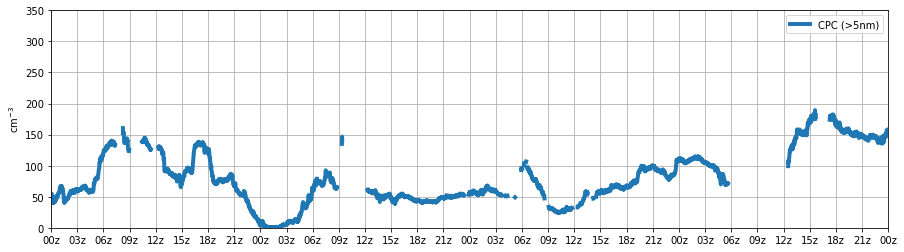

In [49]:
# Plot CPC total aerosol concentration

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(cpc_qc.index,cpc_qc['cpc'], label='CPC (>5nm)',lw=4,zorder=2)   
ax.set_ylabel('cm$^{-3}$')
ax.xaxis.set_major_formatter(md.DateFormatter('%Hz'))
ax.xaxis.set_major_locator(md.HourLocator(interval=3))
ax.set_ylim(0,350)
ax.set_xlim(start_date,stop_date)
ax.legend()           

In [50]:
# Get aerosol size distribution from the SKYOPC

# Extract and qc data from netcdf
var_list=['ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','ambient_aerosol_size_distribution','qc_flag']
lev_list=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,-1]
sky_times,[sky_1,sky_2,sky_3,sky_4,sky_5,sky_6,sky_7,sky_8,sky_9,sky_10,sky_11,sky_12,sky_13,sky_14,sky_15,sky_16,sky_17,sky_18,sky_19,sky_20,sky_qc] = get_nc(ace_path,'aerosol-size-distribution',var_list,lev_list,years,months)
sky_df = pd.DataFrame({1:sky_1,2:sky_2,3:sky_3,4:sky_4,5:sky_5,6:sky_6,7:sky_7,8:sky_8,9:sky_9,10:sky_10,11:sky_11,12:sky_12,13:sky_13,14:sky_14,15:sky_15,16:sky_16,17:sky_17,18:sky_18,19:sky_19,20:sky_20},index=sky_times)
sky_df[sky_qc[:]!=1]=np.nan

# Subset for your selected date range
sky_df = sky_df[start_date:stop_date]

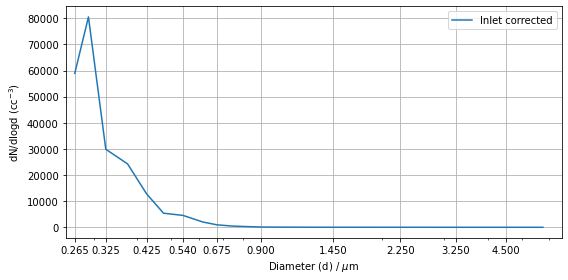

In [51]:
# Plot size distibution

nbins = 20
bounds = [0.25,0.28,0.3,0.35,0.4,0.45,0.5,0.58,0.65,0.7,0.8,1.0,1.3,1.6,2,2.5,3,3.5,4,5,6.5]#,7.5,8.5,10,12.5,15,17.5,20,25,30,32,40]
mid_points = [(bounds[i+1]+bounds[i])/2 for i in range(0,nbins)]
logd = np.log(bounds)   
dlogd = [logd[i+1]-logd[i] for i in range(0,len(mid_points))]

all_hist = sky_df * dlogd

bar_widths=[]
for i in range(0,len(mid_points)):
    bar_widths.append(bounds[i+1]-bounds[i])


fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.grid(True)
#ax.bar(mid_points,dNdlogd,width=bar_widths)
ax.plot(mid_points,sky_df.sum(axis=0),label='Inlet corrected')
#ax.plot(orig_mid_points,orig_dNdlogd,label='Original')

ax.set_xlim(bounds[0],bounds[-1])
#ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

ax.set_xticks(mid_points[0:-1:2])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_xlabel('Diameter (d) / $\mu$m')
ax.set_ylabel('dN/dlogd (cc$^{-3}$)')
#ax.set_title('Aerosol size distribution: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
fig.tight_layout()
#fig.savefig(d_loc + 'Spectra_current.png')
#    fig.clf()